#### Modello Fiaschi 1.0

Struttura vecchia con 3 W:

x -> W0 -> Relu -> W1 -> ReLU -> z -> W2 -> y_cap

In [114]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import torch.linalg as linalg

dataset = torch.tensor([[0.,8.],[1.,8.],[2.,8.],[3.,8.],[4.,8.],
                        [0.,7.],[1.,7.],[2.,7.],[3.,7.],[4.,7.],
                        [0.,6.],[1.,6.],[2.,6.],[3.,6.],[4.,6.],
                        [0.,5.],[1.,5.],[2.,5.],[3.,5.],[4.,5.],
                        [0.,4.],[1.,4.],[2.,4.],[3.,4.],[4.,4.],
                        [0.,3.],[1.,3.],[2.,3.],[3.,3.],[4.,3.],
                        [0.,2.],[1.,2.],[2.,2.],[3.,2.],[4.,2.],
                        [0.,1.],[1.,1.],[2.,1.],[3.,1.],[4.,1.]])

labels = torch.tensor(  [0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,1.,0.,0.,
                         1.,1.,1.,0.,1.,
                         1.,1.,0.,1.,1.,
                         1.,1.,1.,1.,1.,
                         1.,1.,1.,1.,1.])

train_data = []
train_data0 = []
train_data1 = []

for i in range(len(dataset)):
   train_data.append([dataset[i], labels[i]])
   if labels[i] == 0:
      train_data0.append([dataset[i], labels[i]])
   elif labels[i] == 1:
      train_data1.append([dataset[i], labels[i]])

In [115]:
class ModelloF(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size):
        super(ModelloF, self).__init__()
        self.ort_base = None
        
        self.loss = torch.nn.BCEWithLogitsLoss()

        self.W0 = torch.nn.Linear(input_size, hidden_size)
        self.W1 = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.ReLU = torch.nn.ReLU()

        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.Adam(self.parameters())
        
    def forwardL1(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2(W1 * R1(W0 * x))) 
        '''
        
        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(u)

        y = self.W2(v)

        return y, v.clone().detach() # Ritorno sa y che le v (che mi servono per la proiezione)

    def forwardL2(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2( u))
        '''

        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(u)

        v_orto = self._Projection(v)

        y = self.W2(v_orto)
        
        return y


# ----------------------------------------------------------

    def forward(self, x, mode = 'inference'):
        if mode == 'inference':
            with torch.no_grad():
                y, _ = self.forwardL1(x)
            return self.Sigmoid(y)
        elif mode == 'L1':
            return self.forwardL1(x)
        elif mode == 'L2':
            return self.forwardL2(x)
        elif mode == 'inference no sigmoid':
            with torch.no_grad():
                y, _ = self.forwardL1(x)
            return y


    def train(self, dl, mode = 'L1'):
        for x,y in dl:
            self.optimizer.zero_grad()

            if mode == 'L1':
                y_pred, _ = self(x, mode)
            elif mode == 'L2':
                y_pred = self(x, mode)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()
        return e.detach().numpy()
    
    def test(self,dl):
        '''  
        questa funzione testa il modello sul dataset in input usando il modello in modalità L1 (senza la matrice di proiezione)
        ''' 
        for x,y in dl:
            y_pred, _ = self(x,'L1')
            e = self.loss(y_pred,y.unsqueeze(1))
        return e.detach().numpy()

# ----------------------------------------------------------

    def _Projection(self, u):
        # Project u on them and return it
        return torch.mm(u, self.ort_base)

    
    def generate_orthogonal_base(self, dl):
        base = None
        with torch.no_grad():
            for x,y in dl:  
                _, v = self(x, 'L1')
                if base is None:
                    base = v
                else:
                    base = torch.cat((base, v.clone().detach()), dim = 0)
        
        q, r = torch.linalg.qr(base.T, mode = 'reduced')
        diag = torch.diagonal(r)
        mask = torch.where(diag != 0)
        base = q.T[mask] # Base indipendenti, normalizzate
        # BASE Nx10
        #print(base)
        #print(base.size())
        self.ort_base = self._orthogonal_base(base)

    def _orthogonal_base(self, A):
            # A = Nx10
            A = A.T
            # A = 10xN
                
            AAT = torch.matmul(A.T, A)
            # AAT = NxN

            AAT_INV = torch.linalg.solve(AAT, torch.eye(AAT.shape[0])) 
            # AAT_INV = NxN

            P_a = torch.matmul(A, AAT_INV) 
            # P_a = 10xN
            P_a = torch.matmul(P_a, A.T) 
            # P_a = 10x10
            P = torch.eye(P_a.shape[0]) - P_a 
            #print('p')
            #print(P)
            #print(P.size())
            return P

In [116]:
#INIZIALIZZAZIONE SEED, MODELLO E DATALOADERS

torch.manual_seed(66)
modello = ModelloF(2,1,100)
dl0 = torch.utils.data.DataLoader(train_data0, batch_size = 8, shuffle = True)
dl1 = torch.utils.data.DataLoader(train_data1, batch_size = 8, shuffle = True)

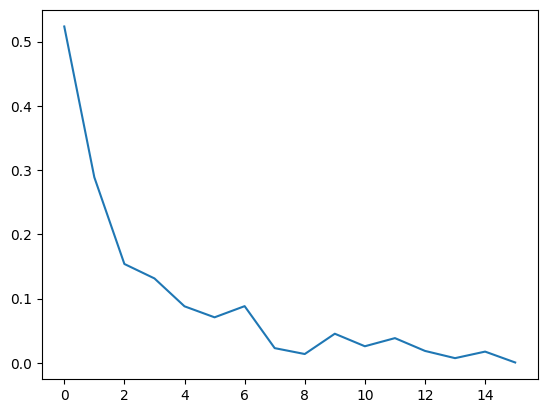

In [117]:
#TRAIN FASE 1
e = 1
err = []
while e > 1e-3:
    e = modello.train(dl1, 'L1') # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err.append(e) 

plt.plot([x for x in range(len(err))], err, label = "Loss")
plt.show()

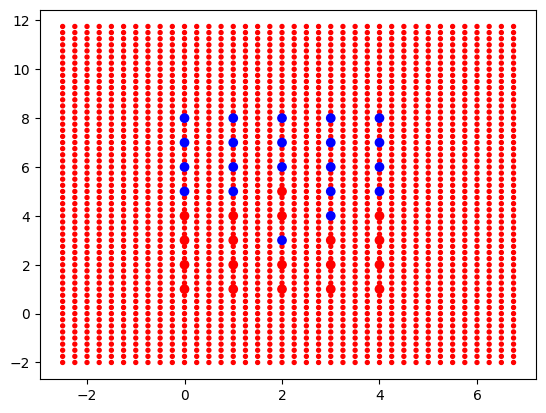

In [118]:
#PLOT FASE 1

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < 0.45 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione

In [119]:
print(modello(torch.tensor([0,0], dtype=torch.float)))

tensor([0.8598])


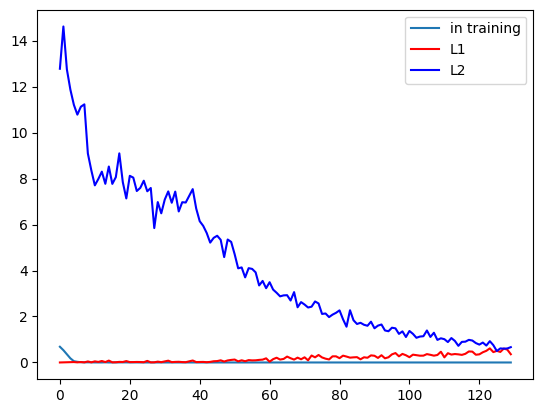

In [120]:
#TRAIN FASE 2

err = []
err_L1 = []
err_L2 = []
modello.generate_orthogonal_base(dl1)

for _ in range(130):
    e = modello.train(dl0, 'L2')
    err.append(e)
    e_L1 = modello.test(dl1)
    err_L1.append(e_L1)
    e_L2 = modello.test(dl0)
    err_L2.append(e_L2)
plt.plot([x for x in range(len(err))], err,label='in training')
plt.plot([x for x in range(len(err_L1))], err_L1,label='L1',color='red')
plt.plot([x for x in range(len(err_L2))], err_L2,label='L2',color = 'blue')
plt.legend()
plt.show()

In [121]:
print(modello(torch.tensor([0,0], dtype = torch.float)))

tensor([0.6907])


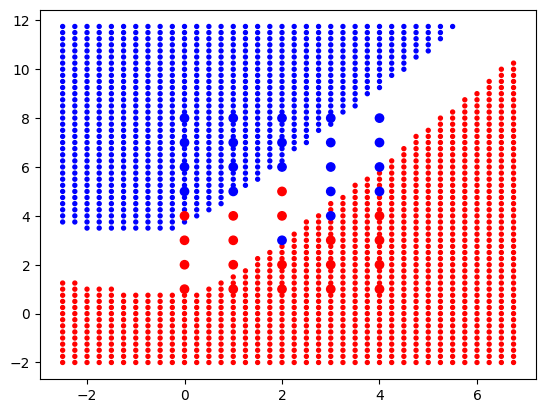

In [122]:
#PLOT FASE 2

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < 0.45 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione